In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

# 参数设置

# 训练参数 
除了路径 其他不要变

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
args.to_save_path     = r"E:\TECO_Works\Conference\ISWC2022\Run_logs"              
args.freq_save_path   = r"E:\TECO_Works\Conference\ISWC2022\Freq_data"
args.window_save_path = r"E:\TECO_Works\Conference\ISWC2022\Sliding_window"
args.root_path        = r"E:\datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 256                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 150

args.learning_rate           = 0.001  
args.learning_rate_patience  = 7
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 0
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## 数据参数



In [3]:
args.seed                             = 1


args.data_name                        =  "wisdm"

args.wavelet_filtering                = False
args.wavelet_filtering_regularization = False
args.wavelet_filtering_finetuning     = False
args.wavelet_filtering_finetuning_percent = 0.5
args.wavelet_filtering_learnable      = False
args.wavelet_filtering_layernorm      = False

args.regulatization_tradeoff          = 0
args.number_wavelet_filtering         = 6


args.difference       = False 
args.filtering        =  False
args.magnitude        =  False
args.weighted_sampler = False




args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]


if args.difference:
    args.c_in = args.c_in*2

if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



## 模型参数

In [4]:
args.filter_scaling_factor = 0.25
args.model_type              = "deepconvlstm_attn"#"deepconvlstm"#"sahar" #"deepconvlstm"
exp = Exp(args)
exp.model

Use GPU: cuda:0
Build the deepconvlstm_attn model!
Done!
Parameter : 24214
Set the seed as :  1


model_builder(
  (model): DeepConvLSTM_ATTN(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (conv1): Conv2d(1, 16, kernel_size=(5, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(5, 1), stride=(2, 1))
      )
      (1): ConvBlock(
        (conv1): Conv2d(16, 16, kernel_size=(5, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(5, 1), stride=(2, 1))
      )
    )
    (lstm_layers): ModuleList(
      (0): LSTM(48, 32, batch_first=True)
      (1): LSTM(32, 32, batch_first=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
    (linear_1): Linear(in_features=32, out_features=32, bias=True)
    (tanh): Tanh()
    (dropout_2): Dropout(p=0.2, inplace=False)
    (linear_2): Linear(in_features=32, out_features=1, bias=False)
    (fc): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [5]:
# cross_channel_interaction_type = "attn",    # attn  transformer  identity
# cross_channel_aggregation_type = "filter",  # filter  naive  FC  "SFCC", "SFCF"
# temporal_info_interaction_type = "gru",     # gru  lstm  attn  transformer  identity  conv
# temporal_info_aggregation_type = "FC",      # naive  filter  FC  tnaive

# 实验

In [8]:
# 如果我们设置为 


args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "lstm"
args.temporal_info_aggregation_type = "tnaive"

exp = Exp(args)

Use GPU: cuda:0
Build the TinyHAR model!
Done!
Parameter : 370082
Set the seed as :  1


In [8]:
exp.model

model_builder(
  (model): TinyHAR_Model(
    (layers_conv): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 26, kernel_size=(5, 1), stride=(2, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(26, 26, kernel_size=(5, 1), stride=(2, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): Conv2d(26, 26, kernel_size=(5, 1), stride=(2, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Sequential(
        (0): Conv2d(26, 26, kernel_size=(5, 1), stride=(2, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (channel_interaction): SelfAttention_intera

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 10 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.0001465  0.000181   0.00097182 0.00123001 0.0004852  0.00060716]
Train data number :  17901
The number of classes is :  6
The input_length  is :  100
The channel_in is :  3
Validation data number :  1989
Test data number :  9947
================ Build the model ================ 
Build the deepconvlstm_attn model!
Epoch: 1 cost time: 8.872799396514893
VALI: Epoch: 1, Steps: 70 | Train Loss: 1.4261068  Vali Loss: 0.9187394 Vali Accuracy: 0.6666667  Vali weighted F1: 0.5601250  Vali macro F1 0.2728398 
Validation loss decreased (inf --> 0.918739).  Sa

Epoch: 27 cost time: 5.887208938598633
VALI: Epoch: 27, Steps: 70 | Train Loss: 0.1490125  Vali Loss: 0.1374897 Vali Accuracy: 0.9557567  Vali weighted F1: 0.9557492  Vali macro F1 0.9429980 
new best score!!!!
Validation loss decreased (0.152888 --> 0.137490).  Saving model ...
new best score!!!!
Epoch: 28 cost time: 5.914208650588989
VALI: Epoch: 28, Steps: 70 | Train Loss: 0.1451581  Vali Loss: 0.1515220 Vali Accuracy: 0.9487179  Vali weighted F1: 0.9489136  Vali macro F1 0.9274779 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 7
Epoch: 29 cost time: 5.895998001098633
VALI: Epoch: 29, Steps: 70 | Train Loss: 0.1435276  Vali Loss: 0.1531321 Vali Accuracy: 0.9487179  Vali weighted F1: 0.9489196  Vali macro F1 0.9374913 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 7
Epoch: 30 cost time: 5.94869065284729
VALI: Epoch: 30, Steps: 70 | Train Loss: 0.1426989  Vali Loss: 0.1392635 Vali Accuracy: 0.9537456  Vali weighted F1: 0.95

Epoch: 57 cost time: 5.87454628944397
VALI: Epoch: 57, Steps: 70 | Train Loss: 0.0930029  Vali Loss: 0.0989069 Vali Accuracy: 0.9648064  Vali weighted F1: 0.9648581  Vali macro F1 0.9540406 
EarlyStopping counter: 11 out of 15
Learning rate adjusting counter: 4 out of 7
Epoch: 58 cost time: 5.8681418895721436
VALI: Epoch: 58, Steps: 70 | Train Loss: 0.0905418  Vali Loss: 0.0983680 Vali Accuracy: 0.9658120  Vali weighted F1: 0.9658731  Vali macro F1 0.9553079 
EarlyStopping counter: 12 out of 15
Learning rate adjusting counter: 5 out of 7
Epoch: 59 cost time: 5.841885805130005
VALI: Epoch: 59, Steps: 70 | Train Loss: 0.0910993  Vali Loss: 0.0978276 Vali Accuracy: 0.9653092  Vali weighted F1: 0.9653767  Vali macro F1 0.9545238 
EarlyStopping counter: 13 out of 15
Learning rate adjusting counter: 6 out of 7
Epoch: 60 cost time: 5.9304585456848145
VALI: Epoch: 60, Steps: 70 | Train Loss: 0.0922838  Vali Loss: 0.0987113 Vali Accuracy: 0.9663147  Vali weighted F1: 0.9663999  Vali macro F1 0.

Epoch: 23 cost time: 5.786476373672485
VALI: Epoch: 23, Steps: 68 | Train Loss: 0.1670579  Vali Loss: 0.1494859 Vali Accuracy: 0.9481597  Vali weighted F1: 0.9477896  Vali macro F1 0.9273446 
new best score!!!!
Validation loss decreased (0.162233 --> 0.149486).  Saving model ...
new best score!!!!
Epoch: 24 cost time: 5.7921411991119385
VALI: Epoch: 24, Steps: 68 | Train Loss: 0.1600990  Vali Loss: 0.1790569 Vali Accuracy: 0.9419388  Vali weighted F1: 0.9402772  Vali macro F1 0.9218290 
EarlyStopping counter: 1 out of 15
Learning rate adjusting counter: 1 out of 7
Epoch: 25 cost time: 5.778265953063965
VALI: Epoch: 25, Steps: 68 | Train Loss: 0.1569615  Vali Loss: 0.1700916 Vali Accuracy: 0.9429756  Vali weighted F1: 0.9426354  Vali macro F1 0.9215134 
EarlyStopping counter: 2 out of 15
Learning rate adjusting counter: 2 out of 7
Epoch: 26 cost time: 5.814982891082764
VALI: Epoch: 26, Steps: 68 | Train Loss: 0.1563817  Vali Loss: 0.1492313 Vali Accuracy: 0.9533437  Vali weighted F1: 0.

Epoch: 52 cost time: 5.801909446716309
VALI: Epoch: 52, Steps: 68 | Train Loss: 0.0873968  Vali Loss: 0.1368416 Vali Accuracy: 0.9631934  Vali weighted F1: 0.9628480  Vali macro F1 0.9562949 
EarlyStopping counter: 3 out of 15
Learning rate adjusting counter: 3 out of 7
Epoch: 53 cost time: 5.915728330612183
VALI: Epoch: 53, Steps: 68 | Train Loss: 0.0820439  Vali Loss: 0.1133018 Vali Accuracy: 0.9631934  Vali weighted F1: 0.9626191  Vali macro F1 0.9530277 
EarlyStopping counter: 4 out of 15
Learning rate adjusting counter: 4 out of 7
Epoch: 54 cost time: 5.828162908554077
VALI: Epoch: 54, Steps: 68 | Train Loss: 0.0838684  Vali Loss: 0.0979018 Vali Accuracy: 0.9699326  Vali weighted F1: 0.9699399  Vali macro F1 0.9615914 
new best score!!!!
Validation loss decreased (0.099650 --> 0.097902).  Saving model ...
new best score!!!!
Epoch: 55 cost time: 5.783450603485107
VALI: Epoch: 55, Steps: 68 | Train Loss: 0.0866414  Vali Loss: 0.0854583 Vali Accuracy: 0.9663038  Vali weighted F1: 0.9

KeyboardInterrupt: 

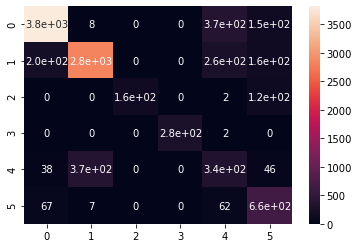

In [6]:
exp.train()

In [ ]:
dataset = data_dict[args.data_name](args)

In [ ]:
import numpy as np

In [ ]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).double().to(exp.device)
print(combined_x.shape)

In [ ]:
out = exp.model(combined_x)
out = out.cpu().detach().numpy()

In [ ]:
out.shape

In [ ]:
weight = exp.model.wave_conv.wavelet_conv.weight.cpu().detach().numpy()

In [ ]:
for n,p in exp.model.named_parameters():
    print(n)

In [ ]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0

plt.figure()
plt.plot(out[0,0,:,index2])
plt.plot(out[0,1,:,index2])
plt.plot(out[0,2,:,index2])
plt.plot(out[0,3,:,index2])

In [ ]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)